**Pour ce chapitre, je prends de nouveau le jeu de données Fashion-MNIST.**

**Je constate l'extrême lenteur de l'entraînement des modèles de ce chapitre : après avoir fait tourner le plus long en vain durant 2 jours entiers (mais à chaque fois colab se déconnectait avant la fin de l'entraînement, et tout était donc perdu...), je suis passée sur le cloud développé par l'INSEE, moins convivial mais beaucoup plus rapide. J'ai donc pu obtenir les résultats.**

**Pour Fashion-MNIST, in fine :**

**- l'entraînement adverse donne de bien moins bons résultats que pour MNIST (taux d'erreur adverse multiplié en gros par 10).**

**- la surface de perte du réseau standard (telle que visible sur le graphe) est raide, mais, à l'inverse de celle de MNIST, est sans rupture de pente.**

**- la surface de perte du réseau robuste est plus "irrégulière" que pour les données MNIST, mais reste, globalement, plate.**

**- il m'a été impossible de faire l'entraînement pour la relaxation, car je ne sais deviner quelle fonction doit remplacer la fonction erronnée dans le programme.**

**- l'entraînement sur les critères prouvables donne des résultats extrêmement médiocres pour les données Fashion-MNIST, alors qu'il était acceptable pour MNIST.**

**Les commentaires détaillés sont en gras dans le corps du notebook.**

In [ ]:
### PREAMBLE
# Chapter 4 - Adversarial training, solving the outer minimization
# linear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Des exemples adverses à l'entraînement de modèles robustes

Dans le chapitre précédent, nous nous sommes concentrés sur les méthodes de résolution du problème de maximisation interne des perturbations, c'est-à-dire trouver la solution au problème suivant :

\begin{equation} \DeclareMathOperator*{\maximize}{maximize} \maximize_{|\delta| \leq \epsilon} \ell(h_\theta(x + \delta), y). \end{equation}


Nous avons couvert trois principales techniques pour cela : la recherche locale basée sur les gradients (fournissant une borne inférieure sur l'objectif), l'optimisation combinatoire exacte (résolvant exactement l'objectif), et les relaxations convexes (fournissant une borne supérieure prouvable sur l'objectif).

Dans ce chapitre, nous revenons au problème min-max que nous avons posé dans le tout premier chapitre, qui correspond à la tâche d'entraîner un modèle robuste aux attaques adversariales ; en d'autres termes, quel que soit l'attaque utilisée par un adversaire, nous voulons avoir un modèle qui fonctionne bien (surtout si nous ne connaissons pas la stratégie précise que l'attaquant va utiliser ; nous en reparlerons dans un instant). C'est-à-dire que, étant donné un ensemble de paires entrée/sortie $S$, nous voulons résoudre le problème de minimisation externe :

\begin{equation} \DeclareMathOperator*{\minimize}{minimize} \minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{|\delta| \leq \epsilon} \ell(h_\theta(x + \delta), y). \end{equation}

L'ordre des opérations min-max est important ici. En particulier, le max est à l'intérieur de la minimisation, ce qui signifie que l'adversaire (cherchant à maximiser la perte) a la possibilité de "déplacer" en second. Nous supposons, essentiellement, que l'adversaire a une connaissance complète des paramètres du classificateur $\theta$ (cela a été implicitement supposé tout au long de la section précédente), et qu'il peut spécialiser son attaque en fonction des paramètres que nous avons choisis dans la maximisation extérieure. L'objectif de la formulation de l'optimisation robuste est donc de s'assurer que le modèle ne peut pas être attaqué même si l'adversaire a une connaissance complète du modèle. Bien sûr, dans la pratique, nous pouvons vouloir faire des hypothèses sur la puissance de l'adversaire : peut-être (ou peut-être pas) est-il raisonnable de supposer qu'il ne pourrait pas résoudre les programmes entiers pour des modèles trop grands. Mais il peut être difficile de définir précisément ce que nous entendons par la "puissance" de l'adversaire, donc une attention particulière doit être portée à l'évaluation des modèles contre des adversaires "réalistes" possibles.

La bonne nouvelle, en quelque sorte, est que nous avons déjà fait une grande partie du travail difficile pour l'entraînement adversarial, lorsque nous avons décrit diverses manières de résoudre approximativement le problème de maximisation interne. Pour chacune des trois méthodes de résolution de ce problème interne (1) borne inférieure via la recherche locale, (2) solutions exactes via l'optimisation combinatoire, et (3) bornes supérieures via les relaxations convexes), il existerait une manière équivalente pour entraîner un système robuste adversarialement. Cependant, la deuxième option n'est pas viable en pratique ; résoudre des programmes entiers est déjà extrêmement chronophage, et l'intégrer davantage dans une procédure d'entraînement (où, en effet, nous devons calculer la solution à un programme entier, avec le nombre de variables égal au nombre d'unités cachées du réseau, à chaque passage sur chaque exemple du dataset) n'est pas une approche pratique. Par conséquent, nous laisserons de côté la possibilité d'intégrer des méthodes exactes d'optimisation combinatoire dans la procédure d'entraînement. Cela nous laisse avec deux choix :

1. Utiliser des bornes inférieures, et des exemples construits via des méthodes de recherche locale, pour entraîner un classificateur robuste adversarialement (empiriquement).
2. Utiliser des bornes supérieures convexes, pour entraîner un classificateur prouvablement robuste.

Il existe des compromis entre ces deux approches : bien que la première méthode puisse sembler moins souhaitable, il se trouve qu'elle crée empiriquement des modèles solides (avec de meilleures performances "propres" empiriquement ainsi que de meilleures performances robustes pour les meilleures attaques que nous pouvons produire). Ainsi, les deux ensembles de stratégies sont importants à considérer pour déterminer comment construire au mieux des modèles robustes adversarialement.



## L'entraînement adverse avec des exemples adverses

La stratégie la plus simple pour entraîner un modèle robuste aux attaques adverses est également celle qui semble la plus intuitive. L'idée de base (qui était à l'origine appelée "entraînement adversarial" dans la littérature en apprentissage automatique, bien que ce soit aussi une technique de base en optimisation robuste lorsqu'on la considère sous cet angle) consiste simplement à créer puis intégrer des exemples adversariaux dans le processus d'entraînement. En d'autres termes, puisque nous savons que l'entraînement "standard" crée des réseaux susceptibles aux exemples adversariaux, pourquoi ne pas simplement entraîner aussi sur quelques exemples adversariaux ?

Bien sûr, la question se pose alors de quels exemples adversariaux nous devrions entraîner. Pour répondre à cette question, revenons à un sujet que nous avons brièvement abordé dans le chapitre introductif. Supposons que nous souhaitions généralement optimiser l'objectif min-max suivant : \begin{equation} \DeclareMathOperator*{\minimize}{minimize} \minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{|\delta| \leq \epsilon} \ell(h_\theta(x + \delta), y). \end{equation} en utilisant la descente de gradient, comment procédons-nous ? Si nous voulons simplement optimiser $\theta$ par descente de gradient stochastique, cela consisterait simplement à calculer à plusieurs reprises le gradient par rapport à $\theta$ pour la fonction de perte sur un mini-lot, et à faire un pas dans cette direction négative. C'est-à-dire que nous voulons répéter la mise à jour suivante : \begin{equation} \theta := \theta - \alpha \frac{1}{|B|} \sum_{x,y \in B} \nabla_\theta \max_{|\delta| \leq \epsilon} \ell(h_\theta(x + \delta), y). \end{equation}

Comment allons-nous calculer ce gradient interne ? Comme nous l'avons mentionné dans le premier chapitre, la réponse est donnée par le théorème de Danskin, qui stipule que pour calculer le (sous)gradient d'une fonction contenant un terme max, nous devons simplement 1) trouver le maximum, et 2) calculer le gradient normal évalué à ce point. En d'autres termes, le gradient pertinent est donné par : \begin{equation} \DeclareMathOperator*{\argmax}{argmax} \nabla_\theta \max_{|\delta| \leq \epsilon} \ell(h_\theta(x + \delta), y) = \nabla_\theta \ell(h_\theta(x + \delta^\star(x)), y) \end{equation} où \begin{equation} \delta^\star(x) = \argmax_{|\delta| \leq \epsilon} \ell(h_\theta(x + \delta), y). \end{equation}

Cependant, notez que le théorème de Danskin ne s'applique techniquement que dans le cas où nous sommes capables de calculer exactement le maximum. Comme nous l'avons appris dans la section précédente, trouver le maximum exactement n'est pas une tâche facile. Et il est très difficile de dire quoi que ce soit de manière formelle sur la nature du gradient si nous ne résolvons pas le problème de manière optimale. Néanmoins, ce que nous trouvons en pratique est ce qui suit : la "qualité" de la procédure de descente de gradient robuste est directement liée à la manière dont nous parvenons à effectuer la maximisation. En d'autres termes, plus nous réussissons à bien résoudre le problème de maximisation interne, plus il semble que le théorème de Danskin commence à être valide. Autrement dit, les aspects clés de l'entraînement adversarial sont d'intégrer une attaque forte dans la procédure de maximisation interne. Et les approches de descente de gradient projetée (encore une fois, cela inclut des variantes simples comme la descente de gradient projetée par le plus grand pente) sont la forme la plus forte d'attaque que la communauté ait trouvée.

Pour résumer, notre stratégie est la suivante :

\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \mbox{1. Select minibatch $B$, initialize gradient vector $g := 0$} \\
& \quad \mbox{2. For each $(x,y)$ in $B$:} \\
& \quad \quad \mbox{a. Find an attack perturbation $\delta^\star$ by (approximately) optimizing } \\
& \qquad \qquad \qquad \delta^\star = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) \\
& \quad \quad \mbox{b. Add gradient at $\delta^\star$} \\
& \qquad \qquad \qquad g:= g + \nabla_\theta \ell(h_\theta(x + \delta^\star), y) \\
& \quad \mbox{3. Update parameters $\theta$} \\
& \qquad \qquad \qquad \theta:= \theta - \frac{\alpha}{|B|} g
\end{split}
\end{equation}

Bien que cette procédure optimise approximativement la perte robuste, ce qui est exactement l'objectif que nous voudrions optimiser, en pratique, il est courant d' ajouter aussi un peu de la perte standard (c'est-à-dire faire aussi des pas de gradient sur les points de données originaux), car cela tend également à améliorer légèrement la performance de l'erreur "standard" de la tâche. Il est également courant de randomiser les positions de départ pour la descente de gradient projetée (PGD), sinon il peut y avoir des problèmes avec la procédure qui apprend une surface de perte de manière à ce que les gradients, exactement aux mêmes points, pointent dans une direction "peu profonde", alors que très près de ces points, il y a des endroits qui ont les surfaces de perte typiquement plus raides des réseaux profonds.


Voyons à quoi cela ressemble en code. Pour commencer, nous allons cloner une partie du code que nous avons utilisé dans le chapitre précédent, y compris les procédures de construction et d'entraînement du réseau, ainsi que celles de production d'exemples adversariaux.

In [ ]:
#préparation du jeu de données fashion-MNIST

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.FashionMNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.1MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 346kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.31MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.67MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [ ]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

La seule véritable modification que nous apportons est que nous modifions la fonction adversariale pour permettre également l'entraînement.




In [ ]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

Commençons par entraîner un modèle standard et évaluer l'erreur adversariale.

In [ ]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

0.343200	0.167400	0.904100
0.148317	0.143200	0.941000
0.123867	0.127300	0.946500
0.111717	0.118000	0.983300
0.102067	0.112000	0.995400
0.084567	0.103500	0.989400
0.082283	0.100100	0.991600
0.081117	0.099100	0.995200
0.079800	0.099800	0.990200
0.077683	0.100800	0.995100


In [ ]:
model_cnn.load_state_dict(torch.load("model_cnn.pt", map_location=torch.device('cpu')))

<ipython-input-7-89ad8c9a32d8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load("model_cnn.pt", map_location=torch.device('cpu')))


<All keys matched successfully>

Comme nous l'avons vu précédemment, l'erreur propre est assez faible, mais l'erreur adversariale est assez élevée (et en réalité, elle augmente à mesure que nous entraînons davantage le modèle). Faisons maintenant la même chose, mais avec un entraînement adversarial.

In [ ]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [ ]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

**Résultats (en faisant tourner mon programme sur le cloud de l'INSEE ouvert aux autres acteurs publics - https://datalab.sspcloud.fr/ -  car sinon colab ne cessait de me déconnecter sans avoir eu le temps de terminer l'exécution de cet entraînement ! --> temps d'exécution catastrophique et ingérable sur colab, qui est en revanche bien plus convivial) :**

0.561167	0.242500	0.383700

0.351983	0.213200	0.333200

0.310300	0.192000	0.300200

0.282683	0.189600	0.292700

0.265950	0.175100	0.273500

0.239233	0.160800	0.248300

0.236350	0.160500	0.247200

0.234917	0.162000	0.248500

0.233583	0.160100	0.242200

0.232817	0.159000	0.242300

In [ ]:
model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt"))

<ipython-input-10-9a33820194a2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt"))


<All keys matched successfully>

### Évaluation des modèles robustes

**Avec l'entraînement adversarial, nous avons obtenu un modèle avec un taux d'erreur de seulement 24 % comparé aux 99 % de notre modèle original. C'est bien moins bon que pour le jeu de données MNIST, pour lequel on passait de 71 % à 2,8 % seulement.**

**Par ailleurs, notre jeu de données Fashion-MNIST permet d'illustrer assez bien cette citation : "(et une meilleure précision de test également, bien que nous souhaitions souligner que cette amélioration de l'erreur propre est un artefact du jeu de données MNIST, et non quelque chose que nous attendons généralement)", puisque la précision de test est au contraire ici légèrement moins bonne.**

En outre, il nous faut rester très, très prudents. Chaque fois que nous entraînons un réseau contre un type spécifique d'attaque, il devient incroyablement facile de performer contre cette attaque particulière à l'avenir : en un sens, c'est juste l'énoncé classique concernant la performance des réseaux profonds : ils sont incroyablement bons pour prédire précisément la classe de données contre laquelle ils ont été entraînés. Mais qu'en est-il si nous utilisons une autre attaque, comme FGSM ? Et si nous utilisons PGD pendant plus longtemps ? Ou avec de la randomisation ? Ou si quelqu'un dans le futur invente une procédure d'optimisation géniale qui fonctionne encore mieux (pour des attaques dans la limite de norme prescrite) ?

Voyons cela en évaluant notre modèle contre différentes attaques. Commençons par essayer FGSM.

In [ ]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])

FGSM:  0.2273


D'accord, c'est une bonne nouvelle. FGSM fonctionne en effet moins bien que l'attaque PGD contre laquelle nous avons entraîné le modèle, car FGSM est en réalité juste un pas de PGD avec une taille de pas de $\alpha = \epsilon$. Il n'est donc pas surprenant que cela fonctionne moins bien. Essayons d'exécuter PGD pendant plus longtemps.

**Contrairement au jeu de données MNIST, dans notre cas, les procédés suivants donnent un taux d'erreur très légèrement supérieur au taux d'erreur de l'entraînement adverse (quelques décimales après la virgule).**

In [ ]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.2459



Aussi bien ! L'erreur augmente un peu, mais reste bien dans les limites de ce que l'on pourrait considérer comme raisonnable (vous pouvez essayer d'exécuter pendant plus longtemps, et constater que cela ne change pas beaucoup... dans la plupart des cas, les exemples ont atteint les limites de la boule $\ell_\infty$, et prendre plus de pas ne modifie pas les résultats). Mais qu'en est-il si nous prenons plus de pas avec une taille de pas plus petite, pour tenter d'obtenir une attaque plus "précise" ?

In [ ]:
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])

PGD, small_alpha:  0.2455


D'accord, nous commençons à être plus confiants maintenant. Ajoutons également de la randomisation.





In [ ]:
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf,
                                             num_iter=40, randomize=True)[0])

PGD, randomized:  0.2456


D'accord, à ce stade, nous avons effectué suffisamment d'évaluations pour être probablement assez confiants pour [mettre le modèle en ligne et voir si quelqu'un peut vraiment le casser](https://github.com/MadryLab/mnist_challenge) (remarque : ce n'est pas réellement le modèle qui a été mis en ligne, bien qu'il ait été entraîné de manière à peu près similaire). Mais nous devrions probablement essayer différents optimiseurs, tenter plusieurs redémarrages randomisés (comme nous l'avons fait dans la section précédente), etc.

Note : Une évaluation qui n'est pas vraiment pertinente (sauf peut-être par curiosité) serait d'évaluer les performances de ce modèle robuste sous une autre région de perturbation, par exemple en évaluant ce modèle robuste $\ell_\infty$ sous une attaque limitée par $\ell_2$. Le modèle a été entraîné sous un seul modèle d'attaque ; bien sûr, il ne fonctionnera pas bien pour prévenir un modèle d'attaque complètement différent. Si l'on désire une sorte de "généralisation" à travers plusieurs modèles d'attaque, il faut alors définir formellement l'ensemble des modèles d'attaque qui nous intéressent, et entraîner le modèle sur plusieurs tirages différents issus de ces modèles d'attaque. C'est un sujet que nous ne traiterons pas ici, sauf pour dire que, pour certaines classes comme les différentes bornes de norme, il serait facile d'étendre l'approche pour défendre simultanément contre, par exemple, les attaques $\ell_1$, $\ell_2$ et $\ell_\infty$, ou quelque chose de similaire. Bien sûr, l'ensemble réel des attaques qui nous intéressent (c'est-à-dire l'ensemble de toutes les images qu'un humain considère comme "raisonnablement similaires") est extrêmement difficile à caractériser, et constitue un excellent sujet pour de futurs travaux.

###Que se passe-t-il avec ces modèles robustes ?

Alors, pourquoi ces modèles fonctionnent-ils bien contre les attaques robustes, et pourquoi certaines autres méthodes proposées pour l'entraînement de modèles robustes (peu ou pas) ont-elles échoué dans ce domaine ? Il y a probablement plusieurs réponses à cette question, mais une réponse potentielle peut être observée en examinant la surface de perte du classificateur entraîné. Regardons une projection de la fonction de perte le long de deux dimensions dans l'espace d'entrée (une dans la direction du gradient réel, et l'autre dans une direction aléatoire).

In [ ]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [ ]:
from mpl_toolkits.mplot3d import Axes3D # Import Axes3D

def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))

    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))

    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())

    fig = plt.figure(figsize=(10,10))
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d') # Use add_subplot to create a 3D subplot
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)


Examinons la surface de perte pour le réseau standard.

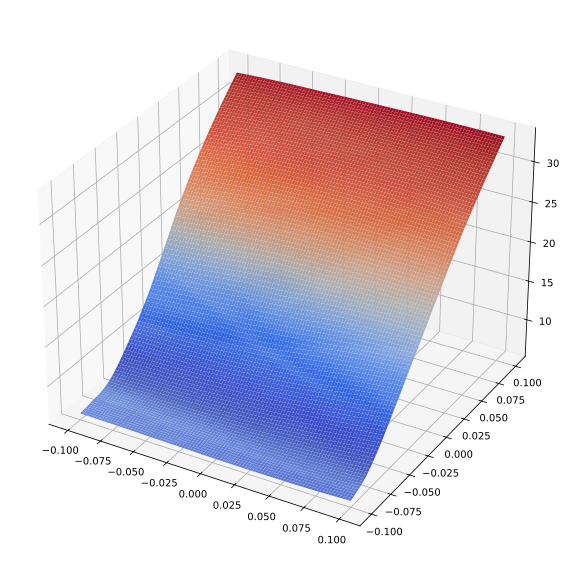

In [ ]:
draw_loss(model_cnn, X[0:1], 0.1)

**Très rapidement, la perte augmente de manière substantielle - mais en ne changeant que peu de pente, contrairement à celle des données MNIST. Comparons cela maintenant au modèle robuste.**






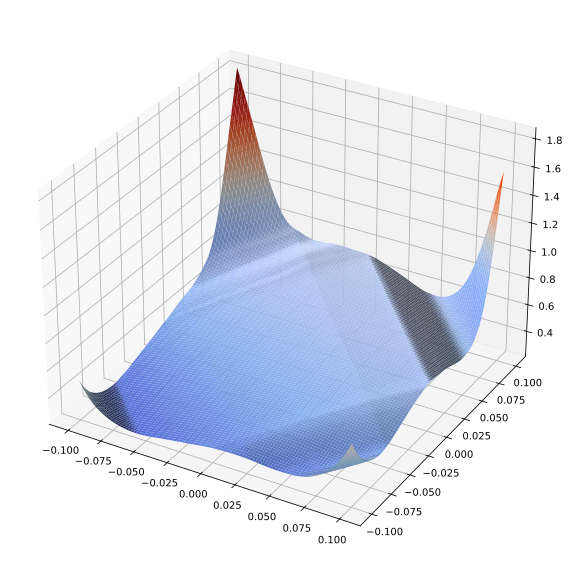

In [ ]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

**La surface est plus "irrégulière" que pour les données MNIST, mais reste globalement "plate", si l'on se réfère à l'axe des z qui va de 0 à 2, contre 0 à 30 dans le cas non robuste.**

Le point important à comparer ici est l'axe $z$ relatif (la "rugosité" dans la deuxième figure est simplement due à l'échelle beaucoup plus petite ; si elle était mise à la même échelle, la deuxième figure serait complètement plate). Le modèle robuste présente une perte assez plate tant dans la direction du gradient (qui est la direction la plus raide), que dans la direction aléatoire, tandis que le modèle entraîné de manière traditionnelle varie assez rapidement tant dans la direction du gradient que (après un certain mouvement dans cette direction) dans la direction aléatoire. Bien sûr, cela ne garantit pas qu'il n'existe pas de direction avec une augmentation abrupte du coût, mais cela donne au moins un indice de ce qui pourrait se passer.

En résumé, ces modèles entraînés avec un entraînement adversarial basé sur PGD semblent être véritablement robustes, dans la mesure où les modèles sous-jacents eux-mêmes ont des surfaces de perte lisses, et non pas grâce à un simple "truc" qui cache la véritable direction d'augmentation du coût. Reste à savoir si l'on peut formuler quelque chose de plus précis sur la robustesse, une question qui reste à explorer, et un sujet de recherche en cours.

## Entrainement robuste basé sur la relaxation

Comme dernière étape, essayons d'utiliser les méthodes de relaxation convexe non seulement pour vérifier les réseaux, mais aussi pour les entraîner. Pour comprendre pourquoi nous voudrions faire cela, nous allons nous concentrer ici sur les bornes basées sur les intervalles, bien que tous les mêmes facteurs s'appliquent également à la relaxation convexe par programmation linéaire, mais dans une moindre mesure (et les méthodes sont beaucoup plus intensives sur le plan computationnel).

Pour commencer, considérons l'utilisation de notre borne par intervalles pour essayer de vérifier la robustesse du classificateur empiriquement robuste que nous venons de former. Rappelez-vous qu'un classificateur est vérifié comme étant robuste contre une attaque adversariale si l'objectif d'optimisation est positif pour toutes les classes ciblées. Cela se fait avec le code suivant (presque entièrement copié du chapitre précédent, mais avec une routine supplémentaire qui calcule la précision vérifiée sur les lots).





In [ ]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []

    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t()
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t()
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)

        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds


def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias

    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()


def robust_bound_error(model, X, y, epsilon):
    initial_bound = (X - epsilon, X + epsilon)
    err = 0
    for y0 in range(10):
        C = -torch.eye(10).to(device)
        C[y0,:] += 1
        err += (interval_based_bound(model, C, bounds, y==y0).min(dim=1)[0] < 0).sum().item()
    return err

def epoch_robust_bound(loader, model, epsilon):
    total_err = 0

    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        for y0 in range(10):
            lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
            total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
    return total_err / len(loader.dataset)

Voyons ce qui se passe si nous essayons d'utiliser cette borne pour voir si nous pouvons vérifier que notre modèle entraîné de manière robuste sera prouvablement insensible aux exemples adversariaux dans certains cas, plutôt que simplement empiriquement.

In [ ]:
epoch_robust_err(test_loader, model_cnn_robust, 0.0005)

NameError: name 'epoch_robust_err' is not defined

**Forcément, puisqu'aucune des fonctions mises en place au-dessus ne porte ce nom...et comment savoir par quoi il faudrait remplacer "epoch_robust_err", parmi ces 4 fonctions ?**

Malheureusement, la borne basée sur les intervalles est complètement vide pour notre classificateur (entraîné de manière robuste). Nous vous épargnerons la déception de vérifier des valeurs de $\epsilon$ de plus en plus petites, et mentionnerons simplement que pour obtenir une véritable vérification avec cette méthode, nous avons besoin de valeurs de $\epsilon$ inférieures à 0.001. Par exemple, pour $\epsilon = 0.0001$, nous parvenons enfin à obtenir une borne "raisonnable".

In [ ]:
epoch_robust_err(test_loader, model_cnn_robust, 0.0001)

NameError: name 'epoch_robust_err' is not defined

**Même remarque...**

Cela ne semble pas particulièrement utile, et en effet, c'est une propriété de pratiquement toutes les approches de vérification basées sur la relaxation : elles sont vides lorsqu'elles sont évaluées sur un réseau entraîné sans connaissance de ces bornes. De plus, ces erreurs ont tendance à s'accumuler avec la profondeur du réseau, précisément parce que les bornes par intervalles, telles que nous les avons présentées, ont également tendance à devenir plus larges à chaque couche du réseau (c'est pourquoi les bornes n'étaient pas si mauvaises dans le chapitre précédent, lorsque nous les appliquions à un réseau à trois couches).

###Entraînement en utilisant des critères prouvables

Alors, si les bornes vérifiables que nous obtenons sont aussi larges, même pour les réseaux empiriquement robustes, quelle en est la valeur ? Il s'avère que, peut-être de manière quelque peu surprenante, si nous entraînons un réseau spécifiquement pour minimiser une perte basée sur cette borne supérieure, nous obtenons un réseau où les bornes sont significatives. C'est un point quelque peu subtil mais important qui mérite d'être répété. En d'autres termes, si nous entraînons un réseau empiriquement...

Pour ce faire, nous allons utiliser les bornes par intervalles pour majorer la perte de l'entropie croisée d'un classificateur, puis minimiser cette borne supérieure. Plus précisément, si nous formons un vecteur "logit" où nous remplaçons chaque entrée par la valeur négative de l'objectif pour une attaque ciblée, puis prenons la perte d'entropie croisée de ce vecteur, cela fonctionne comme une borne supérieure stricte de la perte originale. Nous pouvons implémenter cela de la manière suivante.

In [ ]:
def epoch_robust_bound(loader, model, epsilon, opt=None):
    total_err = 0
    total_loss = 0

    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        total_loss += loss.item() * X.shape[0]
        #print(loss.item())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

Enfin, entraînons notre modèle en utilisant cette borne de perte robuste. Il est important de noter que l'entraînement de modèles robustes est une tâche délicate. Si nous commençons immédiatement à essayer d'entraîner notre borne robuste avec le plein $\epsilon = 0.1$, le modèle va s'effondrer et se contenter de prédire une probabilité égale pour tous les chiffres, sans jamais se redresser. Au lieu de cela, pour entraîner de manière fiable de tels modèles, nous devons planifier $\epsilon$ pendant le processus d'entraînement, en commençant par un petit $\epsilon$ et en l'augmentant progressivement jusqu'au niveau désiré. Le programme que nous utilisons ci-dessous a été choisi de manière assez aléatoire, et nous pourrions obtenir de meilleurs résultats avec quelques ajustements, mais il sert à notre objectif de base.

In [ ]:
torch.manual_seed(0)
model_cnn_robust_2 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2), nn.ReLU(),
                                   nn.Conv2d(32, 32, 3, padding=1, ), nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                   Flatten(),
                                   nn.Linear(7*7*64, 100), nn.ReLU(),
                                   nn.Linear(100, 10)).to(device)

In [ ]:
opt = optim.SGD(model_cnn_robust_2.parameters(), lr=1e-1)
eps_schedule = [0.0, 0.0001, 0.001, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05] + 15*[0.1]

print("Train Eps", "Train Loss*", "Test Err", "Test Robust Err", sep="\t")
for t in range(len(eps_schedule)):
    train_err, train_loss = epoch_robust_bound(train_loader, model_cnn_robust_2, eps_schedule[t], opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust_2)
    adv_err, adv_loss = epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)
    #if t == 4:
    #    for param_group in opt.param_groups:
    #        param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (eps_schedule[t], train_loss, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust_2.state_dict(), "model_cnn_robust_2.pt")

Train Eps	Train Loss*	Test Err	Test Robust Err
0.000000	0.932922	0.179500	1.000000
0.000100	0.479921	0.156400	1.000000
0.001000	0.478009	0.154600	1.000000
0.010000	0.701128	0.174600	1.000000
0.010000	0.543135	0.162300	0.999900
0.050000	2.330141	0.900000	0.900000
0.050000	2.303068	0.900000	0.900000
0.050000	2.302929	0.900000	0.900000
0.050000	2.303098	0.900000	0.900000
0.050000	2.302975	0.900000	0.900000
0.100000	2.303039	0.900000	0.900000
0.100000	2.303037	0.900000	0.900000
0.100000	2.303054	0.900000	0.900000
0.100000	2.303028	0.900000	0.900000
0.100000	2.302983	0.900000	0.900000
0.100000	2.302985	0.900000	0.900000
0.100000	2.303049	0.900000	0.900000
0.100000	2.303134	0.900000	0.900000
0.100000	2.303086	0.900000	0.900000
0.100000	2.302997	0.900000	0.900000
0.100000	2.302937	0.900000	0.900000
0.100000	2.303057	0.900000	0.900000
0.100000	2.302892	0.900000	0.900000
0.100000	2.302921	0.900000	0.900000
0.100000	2.303042	0.900000	0.900000


**Cela ne va pas battre des records, mais ce que nous avons ici est un modèle pour Fashion-MNIST où aucune attaque $\ell_\infty$ de norme bornée par $\epsilon = 0.1$ ne pourra causer plus de 90 % d'erreur sur le jeu de test de Fashion-MNIST (avec une erreur "propre" de 90 % également...).**

**C'est un résultat extrêmement médiocre à comparer de celui pour le jeu de données MNIST, où le taux d'erreur robuste ne dépassait pas les 9.67% (et 5,15 % pour l'erreur "propre").**

Voyons ce que PGD fait.

In [ ]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust_2, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.9


**Donc égal aux deux taux d'erreurs précédents (pour MNIST, le taux d'erreur de PGD était situé entre ces deux taux d'erreurs-ci).** Notez également que l'entraînement de ces modèles robustes prouvables est une tâche difficile, et qu'un peu d'ajustement (même en utilisant toujours les bornes par intervalles) peut permettre d'obtenir de bien meilleurs résultats. Pour l'instant, cependant, cela suffit à démontrer que nous pouvons obtenir des bornes prouvables non triviales pour les réseaux entraînés.

###Le long chemin à parcourir (a.k.a. laisser MNIST derrière soi)

La présentation ici pourrait vous amener à croire que les modèles robustes sont assez proches de leurs homologues traditionnels (quelques points de pourcentage ici ou là). Cependant, bien que nous espérons avoir réussi à vous enthousiasmer pour le potentiel de ces méthodes, il est important de souligner que pour des problèmes à grande échelle, nous sommes loin d'être près de construire des modèles robustes capables d'égaler les modèles standards en termes de performance. Malheureusement, une grande partie de la force apparente de ces modèles provient de notre utilisation de MNIST, où il est particulièrement facile de créer des modèles robustes.

Même sur un jeu de données comme CIFAR10, par exemple, les meilleurs modèles robustes connus, capables de gérer une perturbation de $8/255 = 0.031$ valeurs de couleur, atteignent un erreur robuste (empirique) de 55%, et les meilleurs modèles prouvablement robustes ont une erreur supérieure à 70%. D'un autre côté, les choix que nous avons en ce qui concerne les procédures d'entraînement, l'architecture du réseau, la régularisation, etc., ont à peine été explorés dans le contexte de l'optimisation robuste. Tous nos choix architecturaux proviennent de ce qui a été le mieux pour l'entraînement standard, mais ceux-ci ne sont probablement plus des architectures optimales pour l'entraînement robuste. Enfin, comme nous le soulignerons dans le chapitre suivant, il y a des bénéfices substantiels à tirer des modèles robustes dès maintenant, même si une véritable performance robuste reste encore difficile à atteindre.